# Network Embedding 实例代码与应用

- 简介：网络嵌入方法（Network Embedding）旨在学习网络中节点的低维度潜在表示，所学习到的特征表示可以用作基于图的各种任务的特征，例如分类，聚类，链路预测和可视化。

- 缘由：正如我们知道， 当给定一个社交网络的结构，我们可以预测与节点关联的缺失信息，例如说在一个社交网络图中我们去判断这个是属于哪个社群，或者在网络上的一个网页是属于哪个类别但是由于信息网络可能包含数十亿个节点和边缘，例如用传统的表达发现Adjacency Matrix (graph 1) 去表达一个社交网络结构，但是这种传统的网络表示结构会使得在整个网络上执行复杂的推理过程可能会非常棘手。


- 目的：我们可以使用一种技术来解决这种问题的方式就是网络嵌入 network embedding， 其中心思想就寻找一个映射函数将每一个节点映射到低位的空间。这种低纬度空间表达方式看看做特征用于常见的应用场景，例如分类，距离，链接判断以及可视化。

- 本文将实现以DeepWalk方式实现基于深度学习社区技术的网络嵌入方法，而DeepWalk就是通过将节点视为单词并生成短随机游走作为句子来弥补网络嵌入和单词嵌入之间的差距。然后，可以将诸如 Skip-gram 之类的神经语言模型应用于这些随机游走以获得网络嵌入。

References:
Haochen Chen, Bryan Perozzi2, Rami Al-Rfou2, and Steven Skiena1: A Tutorial on Network Embeddings. August 9, 2018
https://arxiv.org/pdf/1808.02590.pdf

![](adjacency_matrix_graph.png)

- 场景： 我创建了五百个随机节点的网络来演示一个network embeddding 的实现和应用，你可以看到这个社交网络有个三个社区，我们通过embedding 的方式转化其为二维的向量。
![](embedding_graph.png)


In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt

## 1.产生随机数据

In [2]:
#### hiper paramter
walk_length=8
num_nodes = 300
echo =10 ### num of sampling from network
overlap_nodes = 2

### 1) 创建  adjacency matrix（ 邻接矩阵）

In [3]:
def create_adjacency_matrix(num_nodes):
    matrix = []
    num_nodes=num_nodes
    for node in range(num_nodes):
        num_list= [np.random.randint(0,20) for _ in range(num_nodes)]
        if 0 not in num_list:
            randomm_index = np.random.randint(low,num_nodes)
            num_list[randomm_index]=0
        zero_one_list=[]
        for num in num_list:
            if num==0:
                zero_one_list.append(1)
            else:
                zero_one_list.append(0)

        matrix.append(zero_one_list)
    matrix = np.array(matrix)
    for (index,row) in enumerate(matrix):
        matrix[:,index]=row
    
    return matrix

In [4]:
matrix = create_adjacency_matrix(num_nodes=num_nodes)

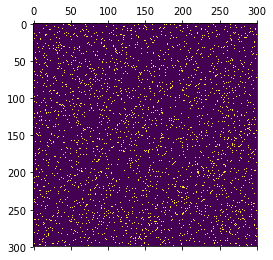

In [5]:
plt.matshow(matrix)

### 2)  创建三个社区群

In [6]:
for row in range(100+overlap_nodes,num_nodes):
    for column in range(0,100):
        matrix[row,column]=0
        matrix[column,row]=0

In [7]:
for row in range(200+overlap_nodes,num_nodes):
    for column in range(0,200):
        matrix[row,column]=0
        matrix[column,row]=0

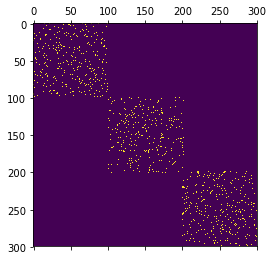

In [8]:
plt.matshow(matrix)

In [9]:
##### 确保每一个节点都能够连接另外的一个节点

In [10]:
for (node_1,row) in enumerate(matrix):
    if 1 not in row:
        randomm_index = np.random.randint(0,num_nodes)
        matrix[node_1,randomm_index]=1


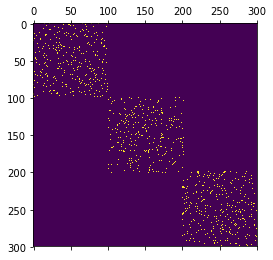

In [11]:
plt.matshow(matrix)

In [12]:
edge_list = [] #### 边集合

In [13]:
for (node_1,row) in enumerate(matrix):
    
    for (node_2,value) in enumerate(row):
        
        if value==1:
            edge_list.append((node_1,node_2))


In [14]:
edge_list[:10] ### 0 -> 15

[(0, 24),
 (0, 73),
 (0, 83),
 (0, 95),
 (0, 97),
 (1, 51),
 (1, 52),
 (1, 60),
 (1, 71),
 (1, 74)]

#### 3) 可视化社交网络图

In [15]:
G = nx.Graph()

In [16]:
G.add_edges_from(edge_list)

In [17]:
node_colors = []

In [18]:
for num in range(num_nodes):
    if num < 100:
        node_colors.append('orange')
    elif num >= 100 and num < 200:
        node_colors.append('plum')
    else:
        node_colors.append('lightcoral')

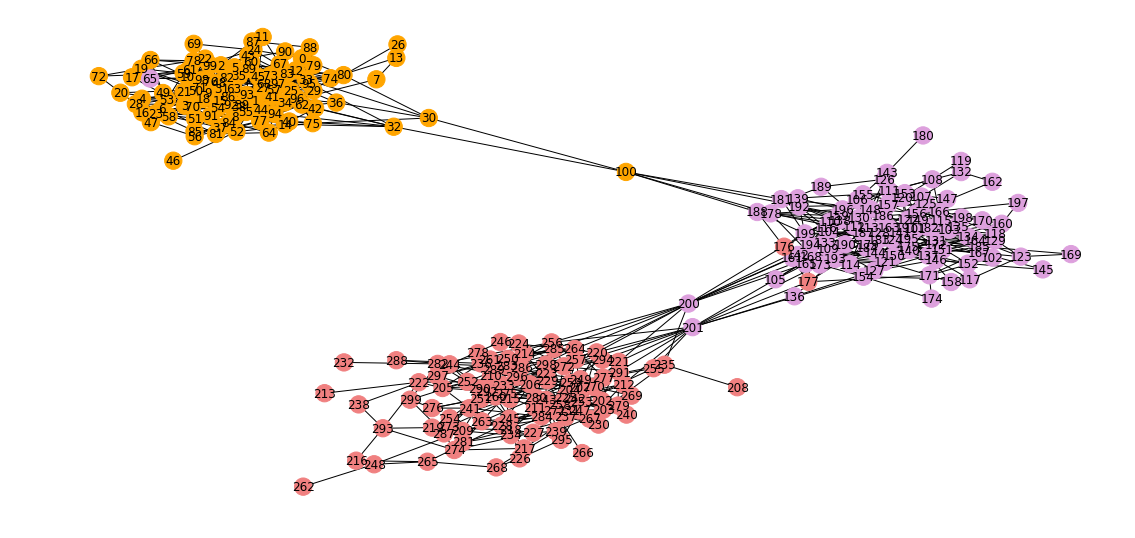

In [19]:
plt.figure(figsize=(15,7))
nx.draw(G,with_labels = True,node_color=node_colors)

## 2. 随机游走的方式进行抽样:
- DeepWalk 通过将节点视为单词并生成短随机游走作为句子来弥补网络嵌入和单词嵌入之间的差距。然后，可以将诸如 Skip-gram 之类的神经语言模型应用于这些随机游走以获得网络嵌入。
- 首先其可以按需生成随机游走。由于 Skip-gram 模型也针对每个样本进行了优化，因此随机游走和 Skip-gram 的组合使 DeepWalk 成为在线算法。

In [20]:
edge_dict ={}

In [21]:
for (node_1,row) in enumerate(matrix):
    
    node_list =[]
    
    for (node_2,value) in enumerate(row):
        
        if value==1:
            
            node_list.append(node_2)
    
    edge_dict[node_1]=node_list
            
            

In [22]:
random_walk_matrix=[]

In [23]:
for _ in range(echo):
    for node in edge_dict:
        start_point = node
        walk_path = [start_point]

        ### select randomly for echo node
        for _ in range(walk_length-1):
            next_point = random.choice(edge_dict[start_point])  
            walk_path.append(next_point)
            start_point = next_point

        random_walk_matrix.append(walk_path)
        

In [24]:
random_walk_matrix=np.array(random_walk_matrix)

In [25]:
random_walk_matrix.shape

(3000, 8)

In [26]:
random_walk_matrix

array([[  0,  97,  80, ...,  69,  24,  69],
       [  1,  60,  59, ...,  37,  84,  37],
       [  2,  87,   5, ...,  79,  88,  33],
       ...,
       [297, 292, 241, ..., 222, 256, 282],
       [298, 291, 298, ..., 255, 277, 264],
       [299, 287, 299, ..., 298, 294, 223]])

### 3. 数据准备: 起始节点 与目标节点对应

In [27]:
root = random_walk_matrix[:,2]

root = root.reshape(-1,1)

roots = np.vstack([root for _ in range(walk_length-1)])

In [28]:
left_right = (walk_length-1)//2

i = list(range(walk_length))

i.remove(left_right)

In [29]:
target_nodes =[]

for num in i:
    temp_nodes = random_walk_matrix[:,num].reshape(-1,1)
    target_nodes.append(temp_nodes)

target_nodes = np.vstack(target_nodes)

target_nodes.shape

(21000, 1)

### 4. Skip-gram 深度学习训练嵌入层

In [30]:
batch_size = 64

In [31]:
def get_batch(X,Y,batch_size):
    batch_sum = 0
    data_size = X.shape[0]
    loop_size = data_size//batch_size
    for _ in range(loop_size):
        x = X[batch_sum:batch_sum+batch_size]
        y = Y[batch_sum:batch_sum+batch_size]
        
        batch_sum+=batch_size
        
        yield x,y

In [32]:
import tensorflow as tf
import tensorflow.contrib.slim as slim

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [33]:
def n_gram(inputs, node_size = 500, n_dim=2, scope='skip-gram', reuse=tf.AUTO_REUSE):
    with tf.variable_scope(scope, reuse=reuse):
        with tf.device('/cpu:0'): ### assign tf using cpu, you may change it when you run the notebook in your env
            embeddings = tf.get_variable('embeddings', shape=[node_size, n_dim], initializer=tf.random_uniform_initializer)
        embed = tf.nn.embedding_lookup(embeddings, inputs)
        net = slim.fully_connected(embed,node_size, activation_fn=None, scope='classification')  
        return net,embeddings

In [34]:
input_ph = tf.placeholder(dtype=tf.int64, shape=[batch_size,1], name='input') 
label_ph = tf.placeholder(dtype=tf.int64, shape=[batch_size,1], name='label')

In [35]:
net,embeddings = n_gram(input_ph,num_nodes,n_dim =2) ### 嵌入维度 n_dim

In [36]:
### define the loss fuction
loss = tf.losses.sparse_softmax_cross_entropy(label_ph, net, scope='loss')

In [37]:
# opt = tf.train.MomentumOptimizer(1e-2, 0.9)
opt =tf.train.AdamOptimizer(1e-2)
train_op = opt.minimize(loss)

In [38]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [39]:
for e in range(60):
    train_losses = []
    
    for path, root in get_batch(roots,target_nodes,batch_size):
        _, curr_loss = sess.run([train_op, loss], feed_dict={input_ph: path, label_ph: root})
        train_losses.append(curr_loss)
        
    if (e + 1) % 20 == 0:
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, np.mean(train_losses)))



Epoch: 20, Loss: 4.32140
Epoch: 40, Loss: 4.29424
Epoch: 60, Loss: 4.28385


In [40]:
embeddings_matrix = embeddings.eval()

In [41]:
x_coords = embeddings_matrix[:,0]
y_coords = embeddings_matrix[:,1]

(-9.77516771094832, 6.068691499400469, -5.681580386489574, 12.337750754684151)

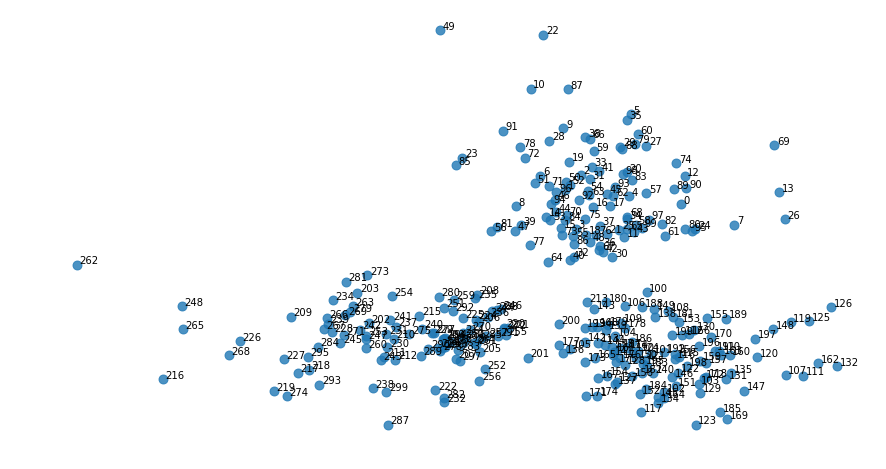

In [43]:
# plt.figure(figsize=(15,8))
# _ = plt.scatter(x_coords, y_coords, color=node_colors,alpha=0.8,s=80)
# for i,node_id in enumerate(list(range(num_nodes))):
#     x = x_coords[i]
#     y = y_coords[i]
#     _ =plt.text(x+0.05, y+0.05,node_id)
# plt.axis('off')

plt.figure(figsize=(15,8))
_ = plt.scatter(x_coords, y_coords,alpha=0.8,s=80)
for i,node_id in enumerate(list(range(num_nodes))):
    x = x_coords[i]
    y = y_coords[i]
    _ =plt.text(x+0.05, y+0.05,node_id)
plt.axis('off')

## 5. 简单的应用： 通过映射到二维的向量后进行聚类分析

In [44]:
from sklearn.cluster import KMeans

In [45]:
random_state = 12

In [46]:
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(embeddings_matrix)

In [48]:
x_coords = embeddings_matrix[:,0]
y_coords = embeddings_matrix[:,1]

(-9.773936812198054, 6.067460600650201, -5.679211313977677, 12.335381682172255)

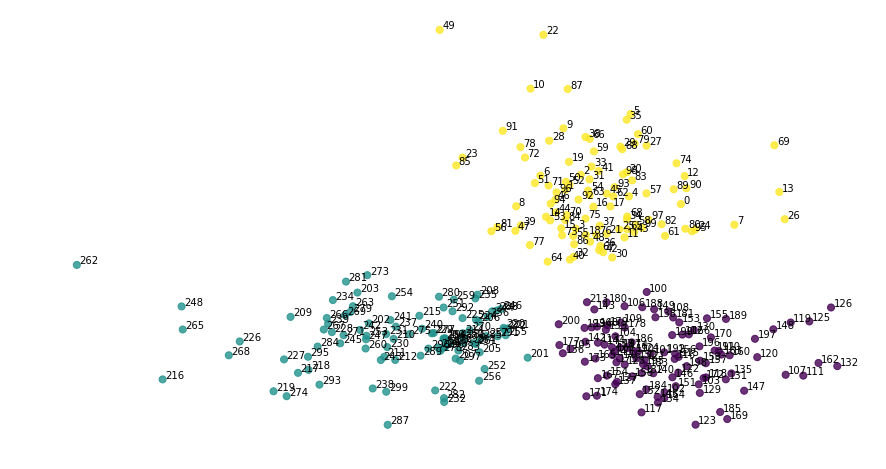

In [49]:
plt.figure(figsize=(15,8))
plt.scatter(embeddings_matrix[:,0],embeddings_matrix[:,1],c=y_pred,alpha=0.8,s =50)
for i,node_id in enumerate(list(range(num_nodes))):
    x = x_coords[i]
    y = y_coords[i]
    _ =plt.text(x+0.05, y+0.05,node_id)
plt.axis('off')

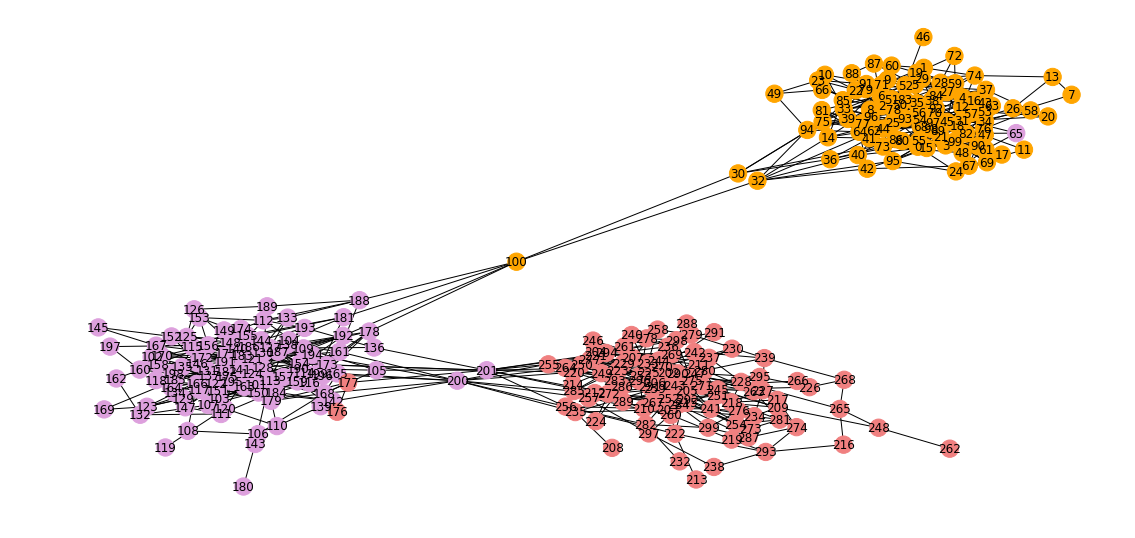

In [50]:
plt.figure(figsize=(15,7))
nx.draw(G,with_labels = True,node_color=node_colors)

### 结论：映射到底维度二维向量后 进行聚类的效果显著，可以准确划分不同的社区。